In [1]:
import os
import ember
import lightgbm as lgb
import shap
import numpy as np
import pandas as pd

binary_name = "mimikatz.bin" #set this to the binary name, put the ones u want to test in /binaries

data_dir = "../ember2018/"

In [3]:
# ~4 mns
binary_location = f"/workspaces/torment-nexus/binaries/{binary_name}"

emberdf = ember.read_metadata(data_dir)
X_train, y_train, X_test, y_test = ember.read_vectorized_features(data_dir, feature_version=2)
lgbm_model = lgb.Booster(model_file=os.path.join(data_dir, "ember_model_2018.txt"))
lgbm_model.params['objective'] = 'regression' # dunno why this never gets set but its needed for shap

[LightGBM] [Warning] Ignoring unrecognized parameter 'max_conflict_rate' found in model string.
[LightGBM] [Warning] Ignoring unrecognized parameter 'sparse_threshold' found in model string.
[LightGBM] [Warning] Ignoring unrecognized parameter 'enable_load_from_binary_file' found in model string.
[LightGBM] [Warning] Ignoring unrecognized parameter 'max_position' found in model string.


In [4]:
# extractor1 = ember.PEFeatureExtractor(1)
extractor2 = ember.PEFeatureExtractor(2)

file_data = open(binary_location, "rb").read()

feature_vector = extractor2.feature_vector(file_data)
raw_features = extractor2.raw_features(file_data)

AttributeError: module 'lief' has no attribute 'bad_file'

In [ ]:
# holy shit this was something else

byte_histogram = [f"Byte Histogram {a}" for a in range(256)] #256

byte_entropy_histogram = [f"Byte Entropy Histogram {a}" for a in range(256)] #256

strings_1 = [f"string.{a}" for a in ["numstrings", "avlength", "printables"]]
strings_2 = [f"string.printabledist_{b}" for b in range(len(raw_features["strings"]["printabledist"]))]
strings_3 = [f"string.{a}" for a in ["entropy", "paths", "urls", "registry", "MZ"]] # 8 + 96
strings = np.concatenate((strings_1,strings_2,strings_3))

general_info = [f"general.{a}" for a in ["size", "vsize", "has_debug", "exports", "imports", "has_relocations", "has_resources", "has_signature", "has_tls", "symbols"]]

header_coff = ["header.coff.timestamp"]
header_coff_machine = [f"header.coff.machine_{a}" for a in range(10)]
header_coff_characteristics = [f"header.coff.characteristic_{a}" for a in range(10)]
header_coff_subsystem = [f"header.optional.subsystem_{a}" for a in range(10)]
header_coff_dll_characteristics = [f"header.optional.dll_characteristic_{a}" for a in range(10)]
header_coff_magic = [f"header.optional.magic_{a}" for a in range(10)]
header_optional = [f"header.optional.{a}" for a in ["major_image_version", "minor_image_version", "major_linker_version", "minor_linker_version", "major_operating_system_version", "minor_operating_system_version", "major_subsystem_version", "minor_subsystem_version", "sizeof_code", "sizeof_headers", "sizeof_heap_commit"]] #12
header = np.concatenate((header_coff,header_coff_machine,header_coff_characteristics,header_coff_subsystem,header_coff_dll_characteristics,header_coff_magic,header_optional))

sections_general = [f"sections.{a}" for a in ["section_count", "num_empty_sections", "num_unnamed_sections", "num_read_execute_sections", "num_write_sections",]] #JUST general
sections_section_sizes = [f"sections.section_{a}_size" for a in range(50)] # this messes with hashing which i will understand at a later time
sections_section_entropy = [f"sections.section_{a}_entropy" for a in range(50)]
sections_section_vsize = [f"sections.section_{a}_vsize" for a in range(50)]
sections_entry_name = [f"sections.entry_name_{a}" for a in range(50)]
sections_characteristics = [f"sections.characteristics_{a}" for a in range(50)]
sections = np.concatenate((sections_general, sections_section_sizes, sections_section_entropy, sections_section_vsize, sections_entry_name, sections_characteristics))

imports_libraries = [f"imports.libraries.library_{a}" for a in range(256)]
imports_imports = [f"imports.import_{a}" for a in range(1024)]
imports = np.concatenate((imports_libraries,imports_imports))

exports = [f"exports.export_{a}" for a in range(128)]

name_order = [a.lower() for a in ["EXPORT_TABLE", "IMPORT_TABLE", "RESOURCE_TABLE", "EXCEPTION_TABLE", "CERTIFICATE_TABLE","BASE_RELOCATION_TABLE", "DEBUG", "ARCHITECTURE", "GLOBAL_PTR", "TLS_TABLE", "LOAD_CONFIG_TABLE","BOUND_IMPORT", "IAT", "DELAY_IMPORT_DESCRIPTOR", "CLR_RUNTIME_HEADER"]]
data_directories_unflat = [[f"directories.{a}_size", f"directories.{a}_vaddress"] for a in name_order]
data_directories = [item for sublist in data_directories_unflat for item in sublist]



feature_names = np.concatenate((byte_histogram, byte_entropy_histogram, strings, general_info, header, sections, imports, exports, data_directories))

[len(byte_histogram) == 256, 
 len(byte_entropy_histogram) == 256, 
 len(strings) == 1 + 1 + 1 + 96 + 1 + 1 + 1 + 1 + 1,
 len(general_info) == 10,
 len(header) == 62, 
 len(sections) == 5 + 50 + 50 + 50 + 50 + 50,
 len(imports) == 1280,
 len(exports) == 128,
 len(data_directories) == 15 * 2,
 len(feature_names) == 2381 # Checks if the feature names are all properly assigned
]

[True, True, True, True, True, True, True, True, True, True]

In [ ]:
explainer = shap.TreeExplainer(lgbm_model, feature_names=feature_names)
shap_values_single = explainer(np.array([feature_vector], dtype=np.float32))

In [ ]:
shap.initjs()

# Plot output

In [ ]:
shap.force_plot(shap_values_single)

In [ ]:
"""
You can see in the above graph that all of the features still have "Feature XXXX" instead of an actual name.
Forunately, there is something resembling a feature name that you can see below
"""
np.array(raw_features)

array({'sha256': '2e8092205a2ded4b07e9d10d0ec02eba0ffcf1d370cab88c5221a749915f678a', 'histogram': [207854, 8658, 4222, 4667, 7997, 2882, 2767, 2608, 10000, 1836, 3337, 3131, 8863, 1550, 2084, 8380, 7353, 1082, 1114, 1064, 4999, 2953, 955, 766, 4010, 822, 707, 984, 2900, 784, 696, 722, 17687, 795, 809, 885, 12194, 3519, 530, 770, 3041, 1427, 1277, 1148, 1840, 981, 1292, 748, 5719, 2152, 2036, 6886, 2632, 1891, 2025, 1651, 3807, 3889, 2472, 6134, 2355, 2146, 1516, 1458, 4662, 2922, 1609, 4468, 6890, 14719, 4743, 3104, 3669, 5770, 2472, 3375, 4254, 5050, 3869, 2832, 10238, 2972, 5429, 7049, 3186, 4086, 5512, 5214, 1737, 9248, 634, 2248, 1387, 2424, 2511, 7581, 1053, 5700, 1375, 3948, 4256, 11278, 3451, 1941, 7997, 5695, 6005, 2755, 5523, 4050, 5566, 5296, 4462, 875, 7333, 6921, 17918, 17640, 2645, 2006, 2988, 2268, 531, 822, 2730, 3438, 1589, 1098, 3064, 1211, 630, 13338, 3374, 9248, 788, 503, 1562, 12462, 1181, 30332, 960, 7436, 501, 376, 818, 362, 292, 637, 897, 509, 381, 344, 950, 718,

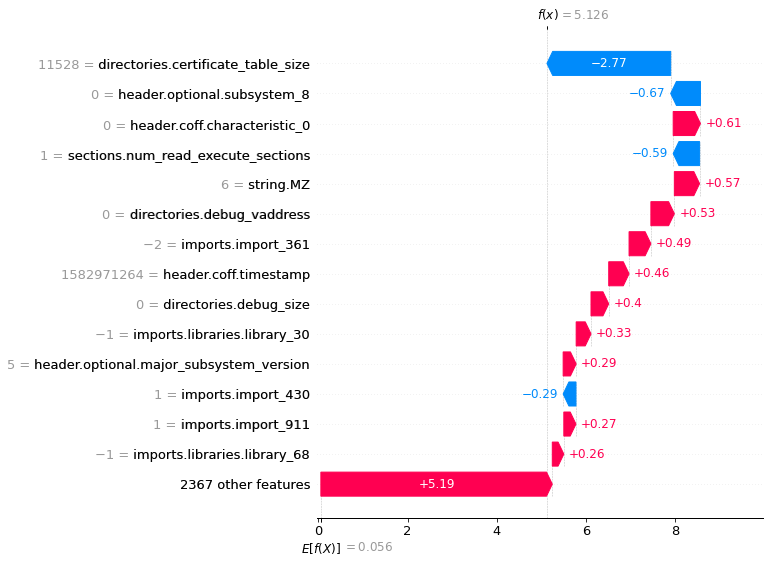

In [ ]:
shap.plots.waterfall(shap_values_single[0], max_display=15)

In [ ]:
shap_values = explainer(pd.DataFrame(X_train[:4000]))
shap.summary_plot(shap_values,feature_names=feature_names,max_display=30)

In [ ]:
from sklearn.feature_extraction import FeatureHasher
feature = raw_features['header']['coff']['characteristics']

print(feature)
print(FeatureHasher(10, input_type="string").transform([feature]).toarray())

for a in range(len(feature)):
    print(f"{[feature[a]]}")
    print(FeatureHasher(10, input_type="string").transform([[feature[a]]]).toarray())


['CHARA_32BIT_MACHINE', 'EXECUTABLE_IMAGE']
[[ 0.  0. -1.  1.  0.  0.  0.  0.  0.  0.]]
['CHARA_32BIT_MACHINE']
[[ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]]
['EXECUTABLE_IMAGE']
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [ ]:
from sklearn.feature_extraction import FeatureHasher

input_string = "beans"
hasher = FeatureHasher(10, input_type="string")
hashed_string = hasher.transform([[input_string, "a", "b", "c"]]).toarray()
hashed_string

array([[ 1., -1.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.]])

In [ ]:
X_train[0]

memmap([0.01467612, 0.00422187, 0.00392268, ..., 0.        , 0.        ,
        0.        ], dtype=float32)